# 2.5 Data Analysis
##  Example 2, Part 5: pH-Rate Profile Example - Kirby 2002

Tony Kirby is one of the giants of physical organic and bio-organic chemistry. In this paper he follows up on a decades-long series of papers investigating the mechanism of *amylases* that catalyze the hydrolysis of acetal groups in polysaccharide chains.

``Concerted general acid and nucleophilic catalysis of acetalhydrolysis. A simple model for the lysozyme mechanism''. K.E.S. Deana, A.J. Kirby, *J. Chem. Soc., Perkin Trans. 2*, **2002**, 428-432. https://doi.org/10.1039/B110948K. 

This *Python* notebook will curve fit the equation for absorbance vs time against kinetic data. We have a set of absorbance measured over 13 hours for 19 reaction performed at various pH values. We want to plot the pH rate profile ($\log{k_{obs}}$ vs pH). First we must determine the rate constant. In this case there are **two rate constants** for two different reactions that produce product.

## The equations

For our reaction system...

$$\text{A} \overset{k_1}{\longrightarrow} \text{I} + \text{P}$$
$$\text{I} \overset{k_2}{\longrightarrow} \text{P}$$

...we state the following differential equations that describe the rate laws...

$$
\begin{align*}
\dfrac{d\left[A\right]_t}{dt} &= -k_1 \left[A\right]_t \\
\dfrac{d\left[I\right]_t}{dt} &= k_1 \left[A\right]_t - k_2 \left[I\right]_t \\
\dfrac{d\left[P\right]_t}{dt} &= k_1 \left[A\right]_t + k_2 \left[I\right]_t
\end{align*}
$$

From this we derived the integrated rate laws and created equations that describe the concentration of each species w.r.t. time.

$$
\begin{align*}

\left[A\right]_t &= \left[A\right]_0 e^{-kt} \\
\left[I \right]_t &= \left[A\right]_{0} \frac{ k_{1} }{k_{1} - k_{2}}\left(e^{- k_{2} t} - e^{- k_{1} t}\right) \\
\left[ P\right]_{t} &= \left[A\right]_{0} \left(- \frac{k_{1} \left(e^{- k_{2} t} - e^{- k_{1} t}\right)}{k_{1} - k_{2}} + 2 - 2 e^{- k_{1} t}\right) \\

\end{align*}
$$

And we can obtain the absorbance contribution from each species using the initial absorbance ($Abs_0$) and the molar extinction coefficients for each species ($\epsilon_A$, $\epsilon_I$, and $\epsilon_P$)

$$\text{Abs}_t = \text{Abs}_0 \left\{ e^{-k_1 t}
             + \frac{\epsilon_I}{\epsilon_A} \frac{k_1}{k_2-k_1}\left(e^{-k_1 t} - e^{-k_2 t} \right)
             + \frac{\epsilon_P}{\epsilon_A} \left[ 2 - 2 e^{-k_1 t} - \frac{k_1}{k_2-k_1}\left(e^{-k_1 t} - e^{-k_2 t}\right) \right] \right\}$$

This is the model to which we will fit the data. Beware! The equation reported in the paper contains typographical errors. The above equation is correct.

## The Data

The data is collected in a single csv file. We can open that file with a text editor, observe its format, and then write python code to import the data into a *Pandas* dataframe. The code below will import the data and display the dataframe. 

In [4]:
#######################
### Environment Setup and Global Variables
#######################

github = False

!mkdir plots

#!pip install uncertainties
#!pip install lmfit

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_11/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_11/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_11/data/"
    image_path = "../Class_11/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"


mkdir: plots: File exists


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv(data_path + "Kirby2002/Abs_t_pH_ALL.csv",
                skipinitialspace=True,
                comment="#"
                )

display(df.head())

time_column = df.columns[0]    # get the column label for the first column (time)
pH_values = df.columns[1:]     # get the column labels that are the pH values


,time (hr),0.00,0.28,0.55,1.00,1.25,1.50,1.90,2.25,2.60,3.40,3.70,4.10,4.40,4.75,5.10,5.60,6.00,6.50,6.90
0,0.00,0.2001,0.2000,0.2001,0.2000,0.2000,0.1997,0.1998,0.2000,0.2002,0.2003,0.1999,0.1997,0.2000,0.2000,0.1999,0.2002,0.1999,0.2002,0.2003
1,0.25,0.1980,0.1957,0.1969,0.1981,0.1989,0.1990,0.1990,0.1988,0.1978,0.1951,0.1918,0.1901,0.1894,0.1910,0.1941,0.1968,0.1985,0.1998,0.1999
2,0.50,0.2096,0.1970,0.1958,0.1965,0.1978,0.1980,0.1977,0.1973,0.1960,0.1911,0.1872,0.1851,0.1848,0.1867,0.1897,0.1948,0.1974,0.1993,0.1998
3,0.75,0.2203,0.2014,0.1953,0.1958,0.1968,0.1966,0.1965,0.1959,0.1941,0.1884,0.1848,0.1826,0.1825,0.1836,0.1874,0.1926,0.1965,0.1988,0.1998
4,1.00,0.2277,0.2065,0.1964,0.1948,0.1965,0.1962,0.1957,0.1952,0.1926,0.1862,0.1835,0.1819,0.1816,0.1824,0.1856,0.1915,0.1953,0.1989,0.1996


## Plot the Data


Always do a quick visual check of your data. Perhaps its all noise? the code below will plot all the abs vs time traces in a single plot.



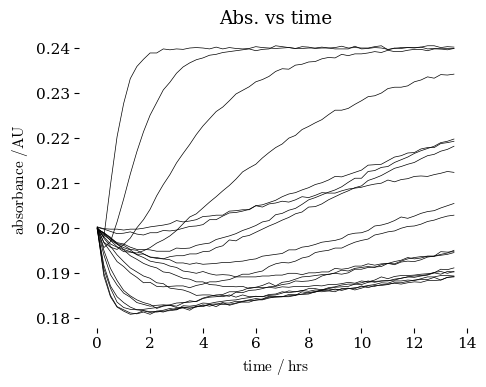

In [6]:
import matplotlib.pyplot as plt

plt.rcdefaults()                              ### resets the plot to defaults 
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x = df[time_column]

for pH in pH_values:

    y = df[pH]             # get absorbance values at a given pH
    
    ax.plot(x, y,          # draw a plot
            marker = None,
            markersize = 3, markeredgewidth = 0.5, 
            markerfacecolor = "white", markeredgecolor = "black",
            linestyle = '-',            ### use a line between points
            linewidth='0.5',            ### make the line thin
            color = 'black',            ### the line is black
            zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
            )
    
ax.set(ylabel=r"$\rm absorbance\ /AU$", 
        xlabel=r"$\rm time\ /\; hrs$",
        title = "Abs. vs time",
        xlim=[None, None],      
   #     ylim=[-0.0, 0.105]
   )

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig("plots/05_Kirby2_"+"ALL"+".pdf")    # use this to save the figure in PDF format
plt.show()

### Many Plots

The code above placed all the lines in a single plot. Small changes can result in separate plots for each run. All that is changing is what commands are inside the loop or outside the loop. See if you can follow the differences and their effects.

In [7]:
import matplotlib.pyplot as plt

plt.rcdefaults()                              ### resets the plot to defaults 
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x = df[time_column]

for pH in pH_values:

    y = df[pH]             # get absorbance values at a given pH
    
    ax.plot(x, y,          # draw a plot
            marker = None,
            markersize = 3, markeredgewidth = 0.5, 
            markerfacecolor = "white", markeredgecolor = "black",
            linestyle = '-',            ### use a line between points
            linewidth='0.5',            ### make the line thin
            color = 'black',            ### the line is black
            zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
            )

    ax.set(ylabel=r"$\rm absorbance\ /AU$", 
            xlabel=r"$\rm time\ /\; hrs$",
            title = "Abs. vs time",
            xlim=[None, None],      
            ylim=[0.175, 0.245])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.savefig("plots/stacking/05_Kirby2_Stacking_"+pH+".pdf")    # use this to save the figure in PDF format

plt.close()

In [8]:
import matplotlib.pyplot as plt

plt.rcdefaults()                              ### resets the plot to defaults 
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   


x = df[time_column]

for pH in pH_values:

    y = df[pH]             # get absorbance values at a given pH
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

    ax.plot(x, y,          # draw a plot
            marker = None,
            markersize = 3, markeredgewidth = 0.5, 
            markerfacecolor = "white", markeredgecolor = "black",
            linestyle = '-',            ### use a line between points
            linewidth='0.5',            ### make the line thin
            color = 'black',            ### the line is black
            zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
            )
    
    ax.text(10,0.18,f"pH = {pH}")

    ax.set(ylabel=r"$\rm absorbance\ /AU$", 
            xlabel=r"$\rm time\ /\; hrs$",
            title = "Abs. vs time",
            xlim=[None, None],      
            ylim=[0.175, 0.245])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.savefig("plots/single/05_Kirby2_Single_"+pH+".pdf")    # use this to save the figure in PDF format
    plt.close()        # close the plot and do not show it in the notebook

## Curve Fit to 1st Order 

Note: the authors inform us that only the very low pH runs fit a standard first-order integrated rate law. Let us model this anyway and see if that is what we observe.

The reaction could be considered to be a simple first order reaction that produces two products. This would be the case if $k_2 \gg k_1$

So for The case...

$$\text{A} \overset{k_{obs}}{\longrightarrow} 2 \text{P}$$

The absorbance change will be the addition of $Abs_A$ and $Abs_P$ and is derived as...

$$\text{Abs}_t = \text{Abs}_0 \left\{ e^{-k_1 t}
             +2 \frac{\epsilon_P}{\epsilon_A} \left[ 1 -  e^{-k_1 t}  \right] \right\}$$

...which is the same as eq. 2 in the paper. Let us fit a set of experimental data to this equation. Consider the code below.

We can curve fit using the derived equation objects from sympy; we can curve fit using the numeric integration function; and we can curve fit a function that we create according to the know equation. this latter method is the simplest to code so that is what we will use.

It can be a problem to fit many variable. If there are variables that are strongly correlated we can end up with a situation where many very different solutions can give a satisfactory fit. We can also have systems that will not minimize as there is too large of a numerical space to explore in search of the minimum.

From previous work (one must go to a PhD thesis at Cambridge to get this data) we know that $\epsilon_P/\epsilon_A = 3.0$ and we have deesigned the experiment in such a way that the initial concentrations of the reactant gives a value for $Abs_0 = 0.100 $ AU. Now we only have to solve for $k_{obs}$

pH is 0.28
parameter names: ['k1']
independent variables: ['t']
[[Model]]
    Model(fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 55
    # variables        = 1
    chi-square         = 6.2914e-04
    reduced chi-square = 1.1651e-05
    Akaike info crit   = -623.817334
    Bayesian info crit = -621.810001
    R-squared          = 0.92325646
[[Variables]]
    k1:  1.3759e-04 +/- 8.2637e-06 (6.01%) (init = 0.02)
For pH 0.28, log(k_obs) = -3.861+/-0.026


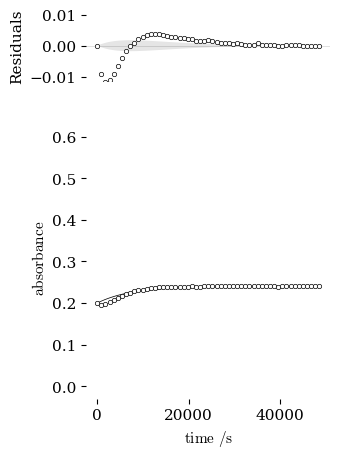

In [9]:
import matplotlib.pyplot as plt
import lmfit     
import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 
from scipy.optimize import curve_fit

pH = pH_values[1]     # choose one of the pH columns
#print(len(pH_values))


def fit_u(t, k1):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    Total_Abs = Abs_0 / eA * (unp.exp(-k1 * t) + 2 * eP * (1 - unp.exp(-k1 * t)))

    return(Total_Abs)      
    
def fit(t, k1):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    Total_Abs = Abs_0 / eA * (np.exp(-k1 * t) + 2 * eP * (1 - np.exp(-k1 * t)))

    return(Total_Abs)      

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

x = df[time_column] * 3600      # time in seconds
y = df[pH]

print(f"pH is {pH}")

##########################
### use lmfit to fit data to function 
##########################

mod = lmfit.Model(fit, nan_policy = 'omit')                  # load the function f as the model to be fit

print(f'parameter names: {mod.param_names}')
print(f'independent variables: {mod.independent_vars}')

                                    # state the parameters (use the text strings that we used above in sympy)
pars = mod.make_params(k1 = dict(value = 0.02, min = 1E-15))    # initial values are also set here
                                    
result = mod.fit(y, pars, t=x)            # use the .fit method on the model object to perform the curve fit
                                            # the variable in this function is 't' so we must use that in the call
##########################
### get the results 
##########################

print(result.fit_report())

k1_fit = result.uvars['k1']

print(f"For pH {pH}, log(k_obs) = {unp.log10(k1_fit)}")

x1 = np.linspace(0, np.max(x), 100)
bestfit_y1 = fit_u(x1, k1_fit)

#######################################################################################

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\rm absorbance$ ", 
          xlabel=r"$\rm time\ /s$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.03,0.65]
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(bestfit_y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(bestfit_y1) + unp.std_devs(bestfit_y1) * sigma
fit_dn = unp.nominal_values(bestfit_y1) - unp.std_devs(bestfit_y1) * sigma

# make filled band
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - fit(x, k1_fit.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)

# make filled band
ax[0].fill_between(x1, unp.std_devs(bestfit_y1) * sigma, -unp.std_devs(bestfit_y1) * sigma, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='lightgray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/05A_Kirby2_1stOrder.pdf")
plt.show()


## Curve Fitting the Model

let us use the equation derived for the reaction scheme as presented in the paper. Note: This is the correct equation, not the erroneous one presented in the paper. We will also fit the equation presented by the authors later in this document just to watch it blow up.

 The code below is almost identical to that above. I changed the functions that represent the model and changed a few other places that used those functions (we have more parameters now). Otherwise its the same: make model, fit model, plot.

pH = 6.50, log(k1) = -4.608+/-0.005, log(k2) = -4.138+/-0.005


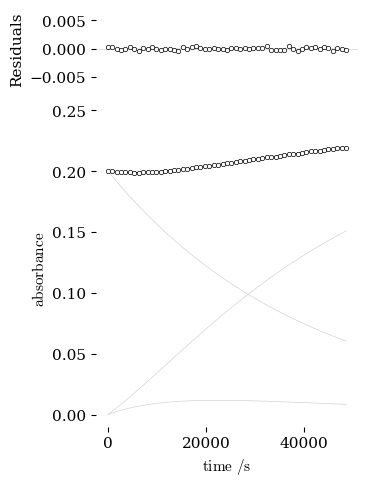

In [10]:
## Calculating line fit and confidence interval using lmfit methods 

sigma = 2


### This function is used in the curve fit. the curve fit tools cannot handle ufloat values    
def f(t, k1, k2):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    
    A0 = Abs_0 / eA
    At = A0 * np.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t))
    Pt = A0 * ((2 - 2 * np.exp(-k1 * t)) - k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t)))
    Total_Abs = At*eA + eI*It + eP*Pt     

    return(Total_Abs)      

pH = pH_values[17]
y = df[pH]
x = df[time_column] * 3600      # time in seconds

##########################
### use lmfit to fit data to function 
##########################

mod = lmfit.Model(f, nan_policy = 'omit')  # load the function f as the model to be fit

                                    # state the parameters (use the text strings that we used above in sympy)
pars = mod.make_params(k1 = dict(value = 0.00001, min = 1E-15),
                       k2 = dict(value = 0.0001, min = 1E-15))    # initial values are also set here
                                    
result = mod.fit(y, pars, t=x)  # Use the .fit method on the model object to perform the curve fit
                                # the variable in this function is 't' so we must use that in the call
##########################
### get the results 
##########################

#   print(result.fit_report())

k1_fit = result.uvars['k1']
k2_fit = result.uvars['k2']

print(f"pH = {pH}, log(k1) = {unp.log10(k1_fit)}, log(k2) = {unp.log10(k2_fit)}")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\rm absorbance$ ", 
          xlabel=r"$\rm time\ /s$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.01,0.25]
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line

bestfit_y1 = result.eval(t=x1)
devs = result.eval_uncertainty(t=x1, sigma = sigma)

ax[1].plot(x1, bestfit_y1, 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################

# upper and lower bounds of uncertain kobs as float values
fit_up = bestfit_y1 + devs
fit_dn = bestfit_y1 - devs

# make filled band
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")



######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual      

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.007,+0.007]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)

# make filled band
ax[0].fill_between(x1, devs, -devs, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

ax[0].axhline(0, color='lightgray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])

######################
### Other elements - add components
######################

def components(t, k1, k2):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    
    A0 = Abs_0 / eA
    At = A0 * np.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t))
    Pt = A0 * ((2 - 2 * np.exp(-k1 * t)) - k1/(k1-k2) * (np.exp(-k2*t)-unp.exp(-k1*t)))
    Abs_A = At * eA 
    Abs_I = eI * It    
    Abs_P = eP * Pt  

    return(Abs_A, Abs_I, Abs_P)   

# calculate Abs contributions for A,I and P using the curve fit parameters
[Abs_A, Abs_I, Abs_P] = components(x1, k1_fit.n, k2_fit.n)

# Plot the calculated contributions from each component
ax[1].plot(x1,Abs_A, 
           marker = None, color = "lightgrey", 
           linewidth=0.5, zorder = 0)
ax[1].plot(x1,Abs_I, 
           marker = None, color = "lightgrey", 
           linewidth=0.5, zorder = 0)
ax[1].plot(x1,Abs_P, 
           marker = None, color = "lightgrey", 
           linewidth=0.5, zorder = 0)

### Output plot
#plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/05B_Kirby2_CorrectModel_lmfit.pdf")
plt.show()


## The Same Thing Again \& Again

The code above performed a curve fit according the the model givem reported the best fit parameters found and then plotted the data and the calculated lined based on the best-fit parameters. But, it only does a single selected set of data at a time.

The code below is identical (almost). I have put it in a loop so that we can iterate through all the columns in the data. The best-fit parameters for $k_1$ and $k_2$ will be collected in lists and then written out as a csv file for further analysis.

In [11]:
import matplotlib.pyplot as plt
import lmfit     
import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 
from scipy.optimize import curve_fit
import pandas as pd

sigma = 2

### This function is used in the curve fit. the curve fit tools cannot handle ufloat values    
def f(t, k1, k2):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    
    A0 = Abs_0 / eA
    At = A0 * np.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t))
    Pt = A0 * ((2 - 2 * np.exp(-k1 * t)) - k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t)))
    Total_Abs = At*eA + eI*It + eP*Pt     

    return(Total_Abs)      

### This function is the same as used in the curve fit. It uses ufloat values and it is used
### when we calculate the line fit and include uncertainties for the confidence interval.    
def f_u(t, k1, k2):

    eA = 1         ### extinction coefficients (ratios)
    eI = 0.3
    eP = 0.6
    Abs_0 = 0.2     ### Initial absorbance
    
    A0 = Abs_0 / eA
    At = A0 * unp.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (unp.exp(-k2*t)-unp.exp(-k1*t))
    Pt = A0 * ((2 - 2 * unp.exp(-k1 * t)) - k1/(k1-k2) * (unp.exp(-k2*t)-unp.exp(-k1*t)))
    Total_Abs = At*eA + eI * It + eP * Pt     

    return(Total_Abs)      

pH_list = []; k1_list = []; k1_list_stdev = []; k2_list = []; k2_list_stdev = []

x = df[time_column] * 3600      # time in seconds
    
for pH in pH_values:     # choose one of the pH columns
    
    y = df[pH]
    pH_value = float(pH)

    ##########################
    ### use lmfit to fit data to function 
    ##########################
    
    mod = lmfit.Model(f, nan_policy = 'omit')  # load the function f as the model to be fit
    
                                        # state the parameters (use the text strings that we used above in sympy)
    pars = mod.make_params(k1 = dict(value = 0.0001, min = 1E-15),
                           k2 = dict(value = 0.00001, min = 1E-15))    # initial values are also set here
                                        
    result = mod.fit(y, pars, t=x)  # Use the .fit method on the model object to perform the curve fit
                                    # the variable in this function is 't' so we must use that in the call
    ##########################
    ### get the results 
    ##########################
    
#    print(result.fit_report())
    
    k1_fit = result.uvars['k1']
    k2_fit = result.uvars['k2']
    
    print(f"pH = {pH_value}, log(k1) = {unp.log10(k1_fit)}, log(k2) = {unp.log10(k2_fit)}")
    
    x1 = np.linspace(0, np.max(x), 100)
    bestfit_y1 = result.eval(t=x1)   # uncertain values - used for confidence interval
    devs = result.eval_uncertainty(t=x1, sigma=sigma)
        
    ###############################################################################
    ######################
    ### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
    ######################
    
    plt.rcdefaults()
    plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  
    
    # Settings for plot
    ax[1].set(
    #          teitle = Title,       
              ylabel=r"$\rm absorbance$ ", 
              xlabel=r"$\rm time\ /s$",                
    #          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
              ylim=[-0.03,0.65]
           )
    
    ### Data graphics
    ax[1].scatter(x, y, marker = "o", s = 10, 
                  color = "white", edgecolors = "black", 
                  linewidths=0.5, zorder = 4) 
    
    # Plot the curve fit line
    ax[1].plot(x1,unp.nominal_values(bestfit_y1), 
               marker = None, color = "black", 
               linewidth=0.5, zorder = 0)
    
    
    ######################
    #### Create Confidence band upper and lower bounds
    ######################
    sigma = 2
    
    # upper and lower bounds of uncertain kobs as float values
    fit_up = bestfit_y1 + devs
    fit_dn = bestfit_y1 - devs
    
    # make filled band
    ax[1].fill_between(x1, fit_up, fit_dn, 
                       facecolor="black", alpha=0.1, zorder = 2,
                       label="confidence interval")
    
    ######################
    #### Add to the Lists
    ######################

    pH_list.append(pH_value) 
    k1_list.append(k1_fit.n)
    k1_list_stdev.append(k1_fit.s)
    k2_list.append(k2_fit.n)
    k2_list_stdev.append(k2_fit.s)

    ######################
    ### Plot the residuals
    ######################
    
    # difference between data and line-fit
    residuals = -result.residual      
    
    ax[0].set(
    #          title = Title,       
              ylabel=r"Residuals", 
              xlabel=r"",                
    #          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.007,+0.007]
           )
    ### Data graphics
    ax[0].scatter(x, residuals, marker = "o", s = 10, 
                  color = "white", edgecolors = "black", 
                  linewidths=0.5, zorder = 3)
    
    # make filled band
    ax[0].fill_between(x1, devs, -devs, 
                       facecolor="black", alpha=0.1, zorder = 1,
                       linewidth = 0, label="confidence interval")
    
    ax[0].axhline(0, color='lightgray', linewidth=0.5, zorder = 0) 
    ax[0].set_xticks([])
    
    ######################
    ### Other elements - add components
    ######################
    
    def components(t, k1, k2):
    
        eA = 1         ### extinction coefficients (ratios)
        eI = 0.3
        eP = 0.6
        Abs_0 = 0.2     ### Initial absorbance
        
        A0 = Abs_0 / eA
        At = A0 * np.exp(-k1 * t)
        It = A0 * k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t))
        Pt = A0 * ((2 - 2 * np.exp(-k1 * t)) - k1/(k1-k2) * (np.exp(-k2*t)-unp.exp(-k1*t)))
        Abs_A = At * eA 
        Abs_I = eI * It    
        Abs_P = eP * Pt  
    
        return(Abs_A, Abs_I, Abs_P)   
    
    # calculate Abs contributions for A,I and P using the curve fit parameters
    [Abs_A, Abs_I, Abs_P] = components(x1, k1_fit.n, k2_fit.n)
    
    # Plot the calculated contributions from each component
    ax[1].plot(x1,Abs_A, 
               marker = None, color = "lightgrey", 
               linewidth=0.5, zorder = 0)
    ax[1].plot(x1,Abs_I, 
               marker = None, color = "lightgrey", 
               linewidth=0.5, zorder = 0)
    ax[1].plot(x1,Abs_P, 
               marker = None, color = "lightgrey", 
               linewidth=0.5, zorder = 0)
    
    ax[1].text(0,0.65,f"pH = {pH}")
    ### Output plot
    plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
    plt.savefig("plots/fits/05B_Kirby2_CorrectModel_pH_"+pH+".pdf")
    plt.close()

df_out = pd.DataFrame({"pH": pH_list,
                       "k1 value": k1_list,
                       "k1 stdev": k1_list_stdev,
                       "k2 value": k2_list,
                       "k2 stdev": k2_list_stdev
                       })

df_out.to_csv("results.csv", index = False)

pH = 0.0, log(k1) = -2.961+/-0.023, log(k2) = -3.182+/-0.011
pH = 0.28, log(k1) = -3.309+/-0.011, log(k2) = -3.535+/-0.005
pH = 0.55, log(k1) = -3.628+/-0.008, log(k2) = -3.8880+/-0.0034
pH = 1.0, log(k1) = -3.873+/-0.007, log(k2) = -4.2124+/-0.0028
pH = 1.25, log(k1) = -4.164+/-0.004, log(k2) = -4.4735+/-0.0018
pH = 1.5, log(k1) = -4.169+/-0.004, log(k2) = -4.7933+/-0.0013
pH = 1.9, log(k1) = -4.1719+/-0.0035, log(k2) = -5.0936+/-0.0019
pH = 2.25, log(k1) = -4.0821+/-0.0028, log(k2) = -5.2757+/-0.0020
pH = 2.6, log(k1) = -3.8898+/-0.0032, log(k2) = -5.3293+/-0.0021
pH = 3.4, log(k1) = -3.484+/-0.005, log(k2) = -5.4133+/-0.0024
pH = 3.7, log(k1) = -3.253+/-0.006, log(k2) = -5.4431+/-0.0023
pH = 4.1, log(k1) = -3.110+/-0.008, log(k2) = -5.4590+/-0.0025
pH = 4.4, log(k1) = -3.077+/-0.007, log(k2) = -5.3941+/-0.0019
pH = 4.75, log(k1) = -3.176+/-0.007, log(k2) = -5.2207+/-0.0016
pH = 5.1, log(k1) = -3.409+/-0.006, log(k2) = -5.2243+/-0.0017
pH = 5.6, log(k1) = -3.759+/-0.005, log(k2) = -4

### The pH-rate profile

We now have best-fit parameters for $k_1$ and $k_2$. We can now plot these values against pH to visualize a pH-rate profile for each reaction. 

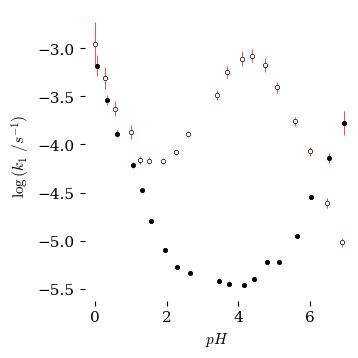

In [12]:
df3 = pd.read_csv("results.csv", skipinitialspace=True, comment="#")

#display(df3.head())

x = df3["pH"]
y1 = unp.uarray(df3["k1 value"],df3["k1 stdev"])
y2 = unp.uarray(df3["k2 value"],df3["k2 stdev"])

y1 = unp.log10(y1)
y2 = unp.log10(y2)

y1n = unp.nominal_values(y1)
y2n = unp.nominal_values(y2)
y1s = unp.std_devs(y1)
y2s = unp.std_devs(y2)

######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,4])  

# Settings for plot
ax.set(ylabel=r"$\log{(k_1\ /s^{-1})}$ ", 
       xlabel=r"$pH$",                
       xlim=[-0.3,7.1],                  
#       ylim=[-0.03,0.65]
       )

### Data graphics
ax.scatter(x, y1n, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 
ax.scatter(x+0.05, y2n, marker = "o", s = 10, 
              color = "black", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 
ax.errorbar(x, y1n, y1s*10, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0)
ax.errorbar(x+0.05, y2n, y2s*10, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0)

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/05B_Kirby2_k1_k2.pdf")
plt.show()


### Examine Your Results

NOTE This was for when...

        eA = 1         ### extinction coefficients (ratios)
        eI = 0.6
        eP = 3
        Abs_0 = 0.1     ### Initial absorbance

...when we created the data. The extinction coefficients have been chageed to better fit the results decribed in the paper and now the line fits work with the same initial values in all cases.

We see that there is a classic pH-rate profile for acid and base catalysis. But the results at higher pH (pH 6.5 and 6.9 have much higher errors that the other line fits (errors shown at $10 \times$ standard deviation so that the difference is obvious). All the points have very small errors. Fitting 50 data points will give small standard deviations, but that doesn't mean your answer is correct. 

The residuals look good for all plots except the highest pH. In this last plot, the line fit looks good, the standard deviation is small (but is 100X greater than in most other fits in the series) however the resisual plot reveals a definite pattern. The residual plots in all other fits is nice and random, but not in the case of the highest pH point.

In the plot above you can see that $k_1$ is faster that $k_2$ in all experiments except the two highest pH points. Our initial conditions for the line fits started with $k_1 > k_2$. The line fit may have failed because of a poor starting position in the line fit. We could address this by setting tighter conditions for convergence but if we are already on a wrong path that may not help.

One simple solution is to begin from a different starting point. If I select a set of starting conditions where $k_1 < k_2$ then we may converge to the correct solution. Return to the code block above that ran a single curve fit. Excgane the initial values for $k_1$ and $k_2$ and examine the resulting plot.

### Change the Results

You will have seen that if we performed the curve fit starting with $k_1 < k_2$ we observed a much better residual plot and tigher standard deviation for the highest pH experiment. This is the best fit. There sometimes is not a single starting point for fitting a mathematical model across a wide range of conditions. Here we see such a case.

I ran the curve fit with the new starting conditions and recorded the following results for pH 6.5 and 6.9:

|pH     | Previous $\log{k_1}$ | Previous $\log{k_2}$ | New $\log{k_1}$      | New $\log{k_2}$      |
|:----- |:-------------- |:-------------- |:-------------- |:-------------- |
| 6.5 | $-4.609\pm 0.006$ | $-4.140\pm 0.027$ | $-4.609\pm 0.006$   |   $-4.140\pm 0.027$ |
| 6.9 | $-4.861\pm 0.008$ | $-4.622\pm 0.034$ | $-5.0175\pm 0.0024$ |   $-3.783\pm 0.023$ |

We see that we have the same result for the pH 6.5 experiment. Both starting conditions led to the same place. However, for the pH 6.9 experiment we see that the best fit values are very different and the errors are much less. Also the residual plot shows a random pattern. This is the best fit.

The error for $k_2$ is high compared to the errors for $k_2$ in other experiments in the series because, when $k_1 < k_2$, the rate of absorbance change is controlled by the r.d.s. $k_1$. There is little information in the data to separate the two contributions. We should run this experiment for a longer time to get more data if we want smaller statistical deviations.

Examine the correlation between $k_1$ and $k_2$ as revealed in the lmfit report. It is a $\% 96$ correlation. When we perform the experiment at pH 4 we see that $k_1 \gg k_2$ and the two effects play out at entirely different time regions of the abs vs time plot (do the curve fit with the code above and see for yourself). Correlation between the two parameters is too small to detect.

So the final two experiments in the series had difficulty fitting for the $k_2$ parameter. The standard deviations are much larger than for the other points. Examination of the residual plot informed me which set of parameters gave the better fit and the results do make more sense when included in the pH rate profile. Remember, you can drop a point just because it looks bad on your graph. here we used math to find a route to a btter curve fit.

Because all of this is contained in this notebook anyone following my work can see my reasoning, repeat the calculations, try entirely different starting conditions for the line fit and eventually satisfy themselves that I am correct.

Kirby's paper gives a fair amount of space to discussing the line fit for the mathematical model of the pH rate profile. Nowhere is it mentioned that the $k_2$ values for the two highest pH experiments are much less confident that the other values. When we apply our own curve fit to the pH rate profiles for $k_1$ and $k_2$ we will include the standard deviation in the fit and that will reduce the weight of these last two experiments in the fiting algorithm. We will very likely get slightly different numbers than the authors. We are only guessing as to the curve fit methods used by the authors, but readers of this series of notebooks will know exactly what we did and will be able to repeat our analysis exactly.

Will you include the code for all your data analysis in the supplemental material for papers you submit to journals? I hope that you will. Interactive notebooks like this provide a standard way to present you code and your arguments together. 

## The Best Fit

I will take the csv file generated previously and change the data in the last line to correspond to the best fit for that experiment as discussed above. Below is the best pH-rate profile for both $k_1$ and $k_2$.

Note: Again us use $10 \times$ the standard deviation for the error bars so that the relative magnitude of the errors is evident. We see that the standard deviations for most points is tiny compared to that for the final two $k_2$ values.

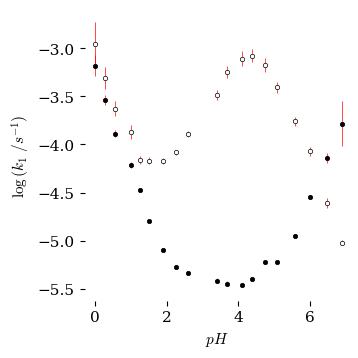

In [13]:
pH6_9_log_k1 = un.ufloat_fromstr("-5.0175+/-0.0024")
pH6_9_log_k2 = un.ufloat_fromstr("-3.783+/-0.023")

df3 = pd.read_csv("results.csv", skipinitialspace=True, comment="#")

x = df3["pH"]
y1 = unp.uarray(df3["k1 value"],df3["k1 stdev"])
y2 = unp.uarray(df3["k2 value"],df3["k2 stdev"])

y1 = unp.log10(y1)
y2 = unp.log10(y2)

y1[-1] = pH6_9_log_k1
y2[-1] = pH6_9_log_k2


y1n = unp.nominal_values(y1)
y2n = unp.nominal_values(y2)
y1s = unp.std_devs(y1)
y2s = unp.std_devs(y2)

######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,4])  

# Settings for plot
ax.set(ylabel=r"$\log{(k_1\ /s^{-1})}$ ", 
       xlabel=r"$pH$",                
       xlim=[-0.3,7.1],                  
#       ylim=[-0.03,0.65]
       )

### Data graphics
ax.scatter(x, y1n, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 
ax.scatter(x, y2n, marker = "o", s = 10, 
              color = "black", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 
ax.errorbar(x, y1n, y1s*10, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0)
ax.errorbar(x, y2n, y2s*10, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0)

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/05B_Kirby2_k1_k2_betterfit.pdf")
plt.show()

### Save the new altered dataframe to a csv file

df_out = pd.DataFrame({"pH": pH_list,
                       "log_k1 value": y1n,
                       "log_k1 stdev": y1s,
                       "log_k2 value": y2n,
                       "log_k2 stdev": y2s
                       })

df_out.to_csv("results2.csv", index = False)

## Conclusion

We now have determined best fit parameters for all the kinetic experiments and plotted them in the pH-rate profile above. Along the way we learned to check the line fits visually by using residual plots. We observed that line fits can be influenced by initial conditions.

In the next notebook we will fit the pH-rate profile to a model for acid-base catalysis.

## Extra: The Wrong Equation

The equation 3 in the paper has two typographical errors. If we were to use it for a curve fit we get nonsense results. Consider the code below that uses the incorrect equation as is. 

pH is 5.60
parameter names: ['k1', 'k2']
independent variables: ['t']
[[Model]]
    Model(fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 55
    # variables        = 2
    chi-square         = 0.04031617
    reduced chi-square = 7.6068e-04
    Akaike info crit   = -393.008476
    Bayesian info crit = -388.993809
    R-squared          = -27.3750121
[[Variables]]
    k1:  0.63291060 +/- 0.01025997 (1.62%) (init = 0.002)
    k2:  7.4595e-07 +/- 6.5836e-07 (88.26%) (init = 0.0002)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.8675
log(k1) = -0.199+/-0.007
log(k2) = -6.1+/-0.4


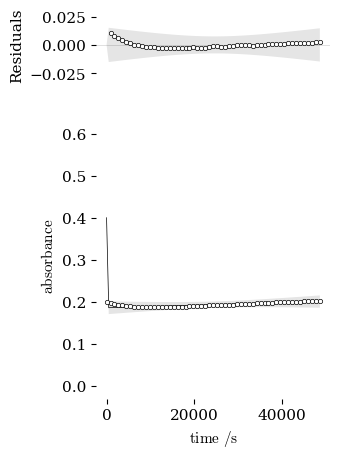

In [14]:
import matplotlib.pyplot as plt
import lmfit     
import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 
from scipy.optimize import curve_fit

pH = pH_values[15]     # choose one of the pH columns
print(f"pH is {pH}")

def fit_u(t, k1, k2):  # wrong equation

    Abs_0 = 0.1; eA = 1; eI = 0.6; eP = 3
    
    A0 = Abs_0 / eA
    At = A0 * unp.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (unp.exp(-k2*t)-unp.exp(-k1*t))
    Pt = A0 * ((2 - 1 * unp.exp(-k1 * t)) - 1/(k1-k2) * (unp.exp(-k2*t)-unp.exp(-k1*t)))
    Total_Abs = At*eA + eI * It + eP * Pt     

    return(Total_Abs)      
    
def fit(t, k1, k2):

    Abs_0 = 0.1; eA = 1; eI = 0.6; eP = 3
    
    A0 = Abs_0 / eA
    At = A0 * np.exp(-k1 * t)
    It = A0 * k1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t))
    Pt = A0 * ((2 - 1 * np.exp(-k1 * t)) - 1/(k1-k2) * (np.exp(-k2*t)-np.exp(-k1*t)))
    Total_Abs = At*eA + eI*It + eP*Pt     

    return(Total_Abs)      

x = df[time_column] * 3600      # time in seconds
y = df[pH]

##########################
### use lmfit to fit data to function 
##########################

mod = lmfit.Model(fit, nan_policy = 'omit')                  # load the function f as the model to be fit

print(f'parameter names: {mod.param_names}')
print(f'independent variables: {mod.independent_vars}')

                                    # state the parameters (use the text strings that we used above in sympy)
pars = mod.make_params(k1 = dict(value = 0.002, min = 1E-15),
                       k2 = dict(value = 0.0002, min = 1E-15))    # initial values are also set here
                                    
result = mod.fit(y, pars, t=x)          # use the .fit method on the model object to perform the curve fit
                                        # the variable in this function is 't' so we must use that in the call
##########################
### get the results 
##########################

print(result.fit_report())

k1_fit = result.uvars['k1']
k2_fit = result.uvars['k2']

print(f"log(k1) = {unp.log10(k1_fit)}")
print(f"log(k2) = {unp.log10(k2_fit)}")

x1 = np.linspace(0, np.max(x), 100)
bestfit_y1 = fit_u(x1, k1_fit, k2_fit)

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\rm absorbance$ ", 
          xlabel=r"$\rm time\ /s$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.03,0.65]
       )

ax[1].scatter(x, y, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(bestfit_y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(bestfit_y1) + unp.std_devs(bestfit_y1) * sigma
fit_dn = unp.nominal_values(bestfit_y1) - unp.std_devs(bestfit_y1) * sigma

# make filled band
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - fit(x, k1_fit.n, k2_fit.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)

# make filled band
ax[0].fill_between(x1, unp.std_devs(bestfit_y1) * sigma, -unp.std_devs(bestfit_y1) * sigma, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='lightgray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/05C_Kirby2_wrongEq.pdf")
plt.show()
